In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# https://www.akshare.xyz/zh_CN/latest/introduction.html
import akshare as ak
import json
import pandas as pd
import numpy as np
import rui_risk_kit as rrk
import fastquotes
import matplotlib.pyplot as plt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing Data

In [4]:
with open('assets.json','r') as myfile:
    data=myfile.read()

porfolio = json.loads(data)

# 构建开放式基金以及货币基金的列表
open_mutual_fund_list = []
currency_mutual_fund_list = []

for open_fund in porfolio['open_fund_in_porfolio']:
    open_mutual_fund_list.append(open_fund)

for currency_fund in porfolio['currency_fund_in_portfolio']:
    currency_mutual_fund_list.append(currency_fund)

In [5]:
currency_fund_info_df = rrk.get_currency_fund_values(currency_mutual_fund_list)
fund_em_info_df = rrk.get_mf_values(open_mutual_fund_list, indicator='累计净值走势')

# concatenate DataFrame(currency_fund_info_df) to Dataframe(fund_em_info_df)
fund_em_info_df = pd.concat([fund_em_info_df, currency_fund_info_df], axis=1)
portfolio_fund_list = open_mutual_fund_list + currency_mutual_fund_list
fund_em_info_df.tail()

,004342,163406,001714,003095,003096,161725,502056,005918,002963,213009,004972
净值日期,,,,,,,,,,,
2021-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7664
2021-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0882,0.7664
2021-06-28,2.2795,8.0852,3.899,4.348,4.296,3.1336,1.7258,1.4648,1.2693,0.5462,0.7836
2021-06-29,2.2573,8.0749,3.893,4.316,4.264,3.1031,1.7236,1.4493,1.2632,0.5386,0.7676
2021-06-30,2.2718,8.1742,3.946,4.325,4.273,3.1157,1.7288,1.4590,1.2515,0.4527,0.6847


In [6]:
# 获取基金规模，代表基金的市值，该数据每季度更新一次
mcaps = {}
for fund in portfolio_fund_list:
    mcaps[fund] = fastquotes.fund.daily.fund_size(fund) * 100000000
mcaps

{'004342': 66000000.0,
 '163406': 26950000000.0,
 '001714': 14803000000.0,
 '003095': 19506000000.0,
 '003096': 20480000000.0,
 '161725': 49914000000.0,
 '502056': 279000000.0,
 '005918': 3744000000.0,
 '002963': 2888000000.0,
 '213009': 11915000000.0,
 '004972': 13032000000.0}

In [7]:
market_prices = ak.stock_zh_index_daily_tx(symbol="sh000300")
market_prices = market_prices.drop(market_prices.columns[[0, -1, -2, -3]], axis = 1)
market_prices.tail()

100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


,close
date,
2021-06-24,5155.97
2021-06-25,5239.97
2021-06-28,5251.76
2021-06-29,5190.54
2021-06-30,5224.04


## Constructing the prior

In [47]:
S = risk_models.CovarianceShrinkage(fund_em_info_df.dropna()).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)

# NEEDS RESEARCH. Extract value from a pandas.core.series.Series
delta = list(delta)[0]

In [46]:
list(delta)[0]

1.6791443495376341

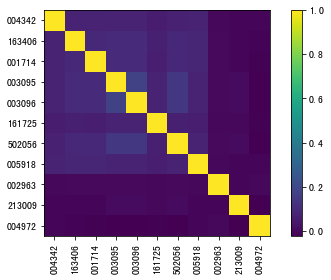

In [9]:
plotting.plot_covariance(S, plot_correlation=True);

In [48]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.023)
market_prior

004342    0.060004
163406    0.180226
001714    0.126816
003095    0.171912
003096    0.175714
161725    0.265501
502056    0.083028
005918    0.078406
002963    0.033795
213009    4.246348
004972    1.977531
dtype: float64

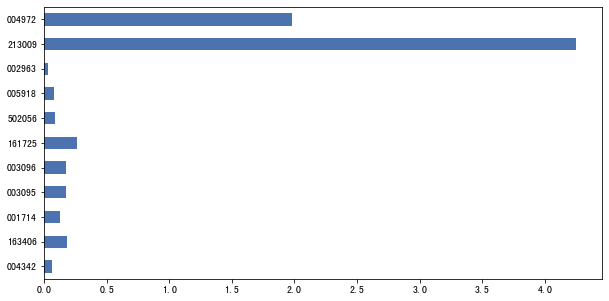

In [49]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [50]:
# You don't have to provide views on all the assets
# viewdict = {
#     "AMZN": 0.10,
#     "BAC": 0.30,
#     "COST": 0.05,
#     "DIS": 0.05,
#     "DPZ": 0.20,
#     "KO": -0.05,  # I think Coca-Cola will go down 5%
#     "MCD": 0.15,
#     "MSFT": 0.10,
#     "NAT": 0.50,  # but low confidence, which will be reflected later
#     "SBUX": 0.10
# }

viewdict = {
    "001714": 0.10,
    "002963": 0.30,
    "003095": 0.05,
    "003096": 0.20,
    "004342": -0.05,
    "004972": 0.15,
    "005918": 0.10,
    "161725": 0.12,
    "163406": 0.13,
    "213009": 0.14,
    "502056": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [51]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4,
    0.2
]

In [52]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

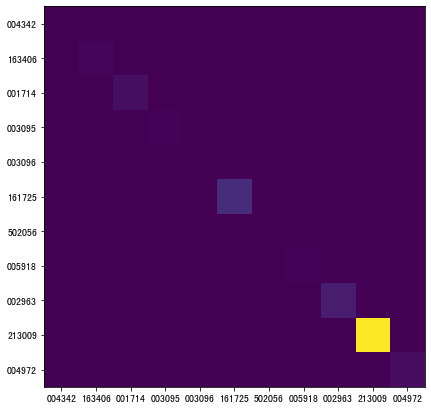

In [53]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [54]:
np.diag(bl.omega)

array([0.01478578, 0.03092017, 0.09602492, 0.02400051, 0.00916738,
       0.3330282 , 0.00930033, 0.02152426, 0.19895302, 2.63408143,
       0.09197181])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [55]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.3)
]

In [56]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [57]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [58]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

004342   -0.040599
163406    0.151533
001714    0.101907
003095    0.090496
003096    0.188006
161725    0.122308
502056    0.076066
005918    0.094626
002963    0.150482
213009    0.192369
004972    0.156020
dtype: float64

We can visualise how this compares to the prior and our views:

In [59]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
004342,0.060004,-0.040599,-0.05
163406,0.180226,0.151533,0.13
001714,0.126816,0.101907,0.10
003095,0.171912,0.090496,0.05
003096,0.175714,0.188006,0.20
161725,0.265501,0.122308,0.12
502056,0.083028,0.076066,0.10
005918,0.078406,0.094626,0.10
002963,0.033795,0.150482,0.30
213009,4.246348,0.192369,0.14


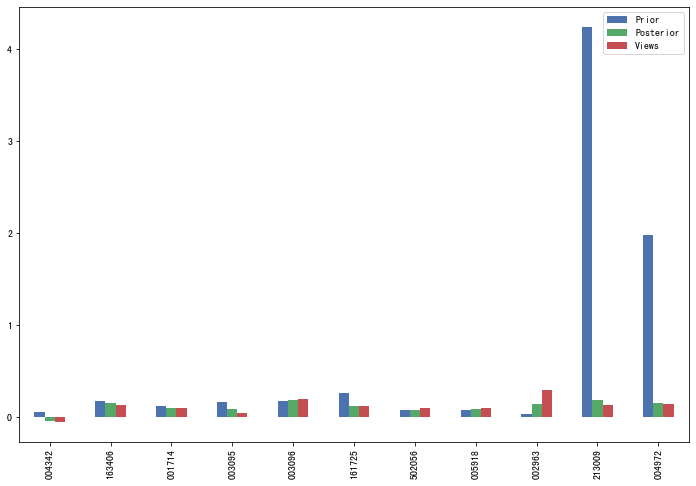

In [60]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

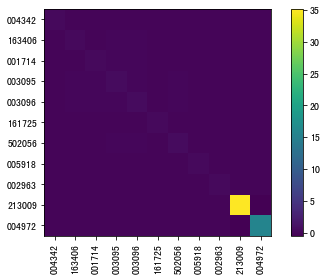

In [61]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [62]:
from pypfopt import EfficientFrontier, objective_functions

In [63]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/opt/anaconda3/lib/python3.7/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:253: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('004342', 0.0),
             ('163406', 0.16094),
             ('001714', 0.09245),
             ('003095', 0.06704),
             ('003096', 0.20526),
             ('161725', 0.12778),
             ('502056', 0.05091),
             ('005918', 0.08599),
             ('002963', 0.18105),
             ('213009', 0.00988),
             ('004972', 0.0187)])

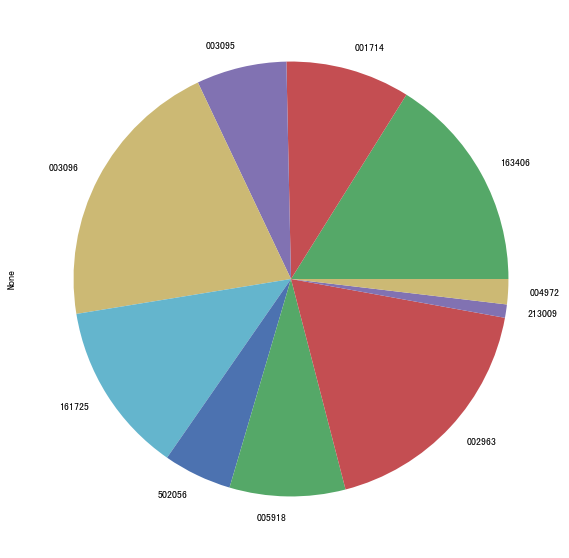

In [64]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [65]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, fund_em_info_df.iloc[-1], total_portfolio_value=300000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

NameError: Solver GLPK_MI is not installed. 

In [70]:
total_portfolio_value = 300000

total = 0
for asset in pd.Series(weights):
    total += asset
    print(total)

0.0
0.16094
0.25339
0.32043
0.52569
0.65347
0.70438
0.79037
0.97142
0.9813
1.0
